In [1]:
suppressMessages({
    library(udunits2)
    library(RNetCDF)
    library(dplyr)
    library(tidyr)
    library(ggplot2)
    # library(rmaptools)
    library(mapview)
    library(sf)
    library(leaflet)
    library(sfheaders)
    library(parallel)
    library(terra)
    library(grid)
    library(forcats)
    })


In [6]:
#QA/QC'd gauges to remove some with mutliple gauges. We should do that here
bad_gauges=data.frame(reach_id=read.delim('/nas/cee-water/cjgleason/colin/SWOT_global_Q_paper/multi_gauge_reaches.txt'),bad=TRUE)
names(bad_gauges)=c('reach_id','bad')

In [3]:
#get rid of bad gauges
gauge_swot_spearman= readRDS('/nas/cee-water/cjgleason/colin/SWOT_global_Q_paper/gauge_swot_model_spearman.rds')%>%
    mutate(reach_id=as.numeric(reach_id))%>%
    left_join(bad_gauges,by='reach_id')%>%
    filter(is.na(bad))%>%
    select(-bad)

names(gauge_swot_spearman)

[1] "SWOT_spearman" "ML_spearman"   "trad_spearman" "all_spearman" 
[5] "reach_id"

Warning message:
“Removed 7 rows containing non-finite outside the scale range (`stat_ecdf()`).”
Warning message:
“Removed 7 rows containing non-finite outside the scale range (`stat_ecdf()`).”


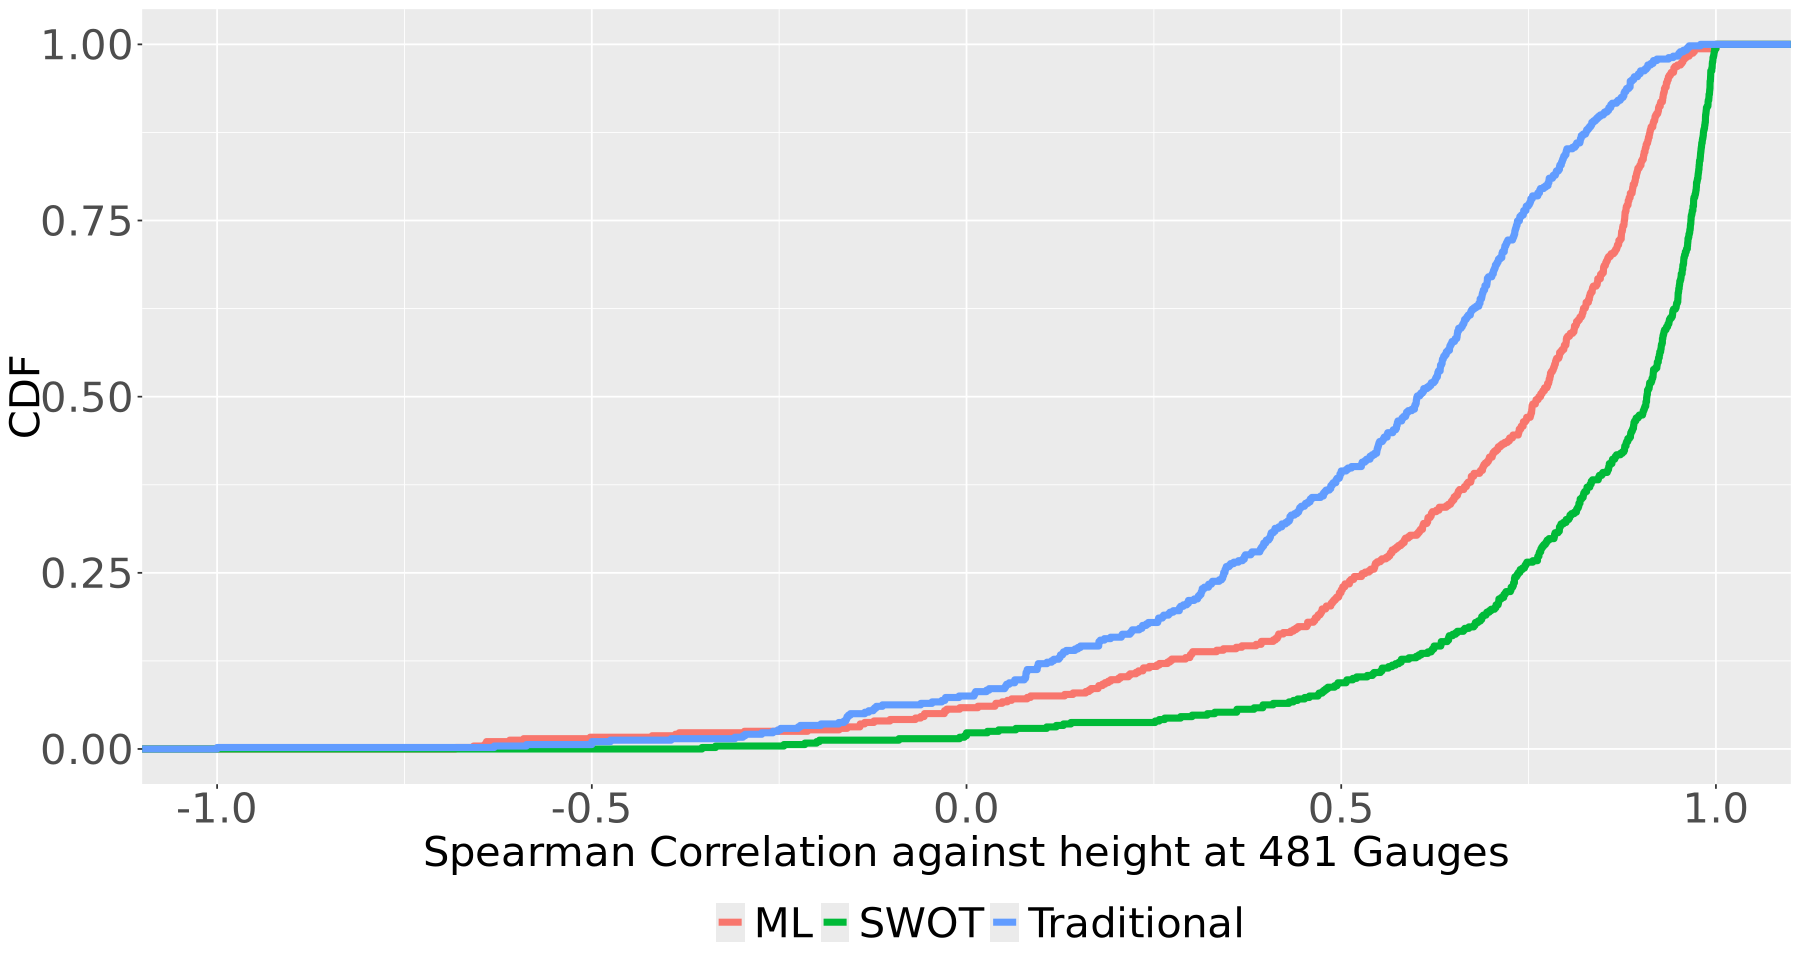

In [4]:
plotter=gather(gauge_swot_spearman,model, value,-reach_id)%>%
    filter(model!='all_spearman')

plotter$model[plotter$model=='ML_spearman']='ML'
plotter$model[plotter$model=='trad_spearman']='Traditional'
# plotter$model[plotter$model=='all_spearman']='All'
plotter$model[plotter$model=='SWOT_spearman']='SWOT'

num_gauges=length(unique(plotter$reach_id))

p4=ggplot(plotter)+
    stat_ecdf(aes(x=value,col=model),lwd=2)+
    scale_x_continuous(name=paste0('Spearman Correlation against height at ',num_gauges,' Gauges'), limits=c(-1, 1))+
    # scale_colour_brewer(palette='Dark2')+
    # scale_linewidth_manual(values=c(1,3), guide='none')+
    theme(title=element_text(size=25),
          legend.text=element_text(size=25),
          legend.title=element_blank(),
          axis.text=element_text(size=25),
          axis.title=element_text(size=25),
          legend.position='bottom')+
    # xlab('Spearman Correlation against Gauge height')+
    ylab('CDF')
   # ggtitle(paste0("Skill at ",num_gauges, " gauges"))
    # ggtitle(paste('SWOT height and Ensemble flow Spearman correlation with gauged height at',length(unique(gauge_swot_spearman$reach_id)),'gauges in Science Orbit'))

p5 = ggplot(plotter)+
    geom_violin(aes(x=model,y=value,fill=model))+
      # scale_fill_manual(values = colors)+
    theme(legend.text=element_text(size=18),
             legend.title=element_text())+
theme(legend.position='none')+
    theme(axis.text=element_text(size=18))+
    theme(axis.title=element_text(size=18))+
    ylab('Spearman Correlation')+
    xlab('')
options(repr.plot.width=15, repr.plot.height=8)
 p4
# p5

ggsave(plot=p4,'/nas/cee-water/cjgleason/colin/SWOT_global_Q_paper/Figures/gauge_speamans.png',width=15,height=8)

In [1]:
suppressMessages({
    library(udunits2)
    library(RNetCDF)
    library(dplyr)
    library(tidyr)
    library(ggplot2)
    # library(rmaptools)
    library(mapview)
    library(sf)
    library(leaflet)
    library(sfheaders)
    library(parallel)
    library(terra)
    library(grid)
    library(forcats)
    })


In [8]:
filtered_input=readRDS('/nas/cee-water/cjgleason/colin/SWOT_global_Q_paper/filtered_height_validation_df.rds')%>%
    transmute(reach_id=reach_id,abs_error=abs_rel_unsmoothed_filtered_error,type='filtered')%>%
#to make plot, does not affect stats
        filter(abs_error<1000)

filtered_errors=round(quantile(filtered_input$abs_error,probs=c(0.5,0.68),na.rm=TRUE),digits=2)

unfiltered_input=readRDS('/nas/cee-water/cjgleason/colin/SWOT_global_Q_paper/unfiltered_height_validation_df.rds')%>%
    transmute(reach_id=reach_id,abs_error=unsmoothed_unfiltered_swot_abs_rel_error,type='unfiltered')%>%
#to make plot, does not affect stats
        filter(abs_error<1000)

 unfiltered_errors=round(quantile(unfiltered_input$abs_error,probs=c(0.5,0.68),na.rm=TRUE),digits=2)

suppressWarnings({
# all_relative_errors=full_join(filtered_input,unfiltered_input,by='reach_id')
    all_relative_errors=rbind(filtered_input,unfiltered_input)
    
})

In [9]:
nrow(all_relative_errors)

[1] 177588

In [10]:
filtered_errors
unfiltered_errors

50%  68% 
0.09 0.15

50%  68% 
0.29 0.64

In [11]:
head(all_relative_errors)
# min(all_relative_errors)
max(all_relative_errors$abs_error)

reach_id,abs_error,type
<dbl>,<dbl>,<chr>
71181300781,0.0684,filtered
71181300781,0.0594,filtered
71181300781,0.0428,filtered
71181300781,0.1179,filtered
71181300781,0.1369,filtered
71181300781,0.0500,filtered


[1] 788.1135

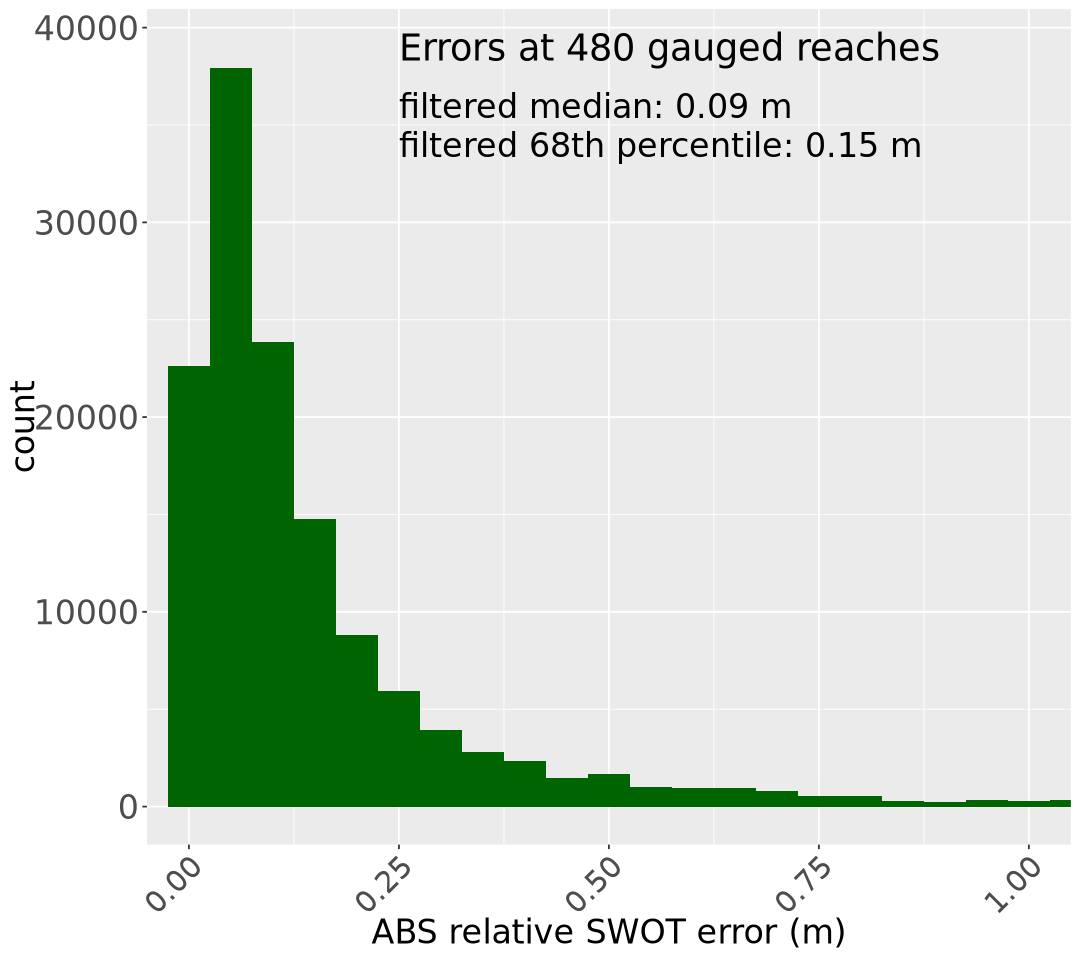

In [24]:
plot_height_error=filtered_input

p2=ggplot(plot_height_error)+
   # geom_density(aes(x=abs_error,fill=type))+
    geom_histogram(aes(x=abs_error, fill=type),binwidth=0.05)+
  scale_fill_manual(values=c('dark green'))+#,'pink'))+

coord_cartesian(xlim=c(0,1))+
      ylab('count')+
     xlab('ABS relative SWOT error (m)')+
theme(legend.position = 'none',
    legend.background = element_rect(fill='transparent'),
         legend.box.background = element_rect(color='transparent',fill='transparent'))+

         theme(axis.title.y=element_text(size=20))+
 theme(axis.title.x=element_text(size=20))+
         # theme(legend.title=element_blank())+
         #    theme(legend.text=element_text(size=20))+
         theme(axis.text.x=element_text(size=18, angle=45,hjust=1))+
         theme(axis.text.y=element_text(size=20))+
    theme(title=element_text(size=20))+
annotate('text', label=paste('Errors at',length(unique(filtered_input$reach_id)),'gauged reaches'), x=0.25,y=3.9e4,hjust=0,size = 22/.pt)+
    # annotate('text', label=paste('unfiltered median:',unfiltered_errors[1],'m'), x=0.25,                        y=3.6e4,hjust=0,size = 20/.pt)+
    # annotate('text', label=paste('unfiltered 68th percentile:',unfiltered_errors[2],'m'), x=0.25,               y=3.4e4,hjust=0,size = 20/.pt)+
    annotate('text', label=paste('filtered median:',filtered_errors[1],'m'), x=0.25,                            y=3.6e4,hjust=0,size = 20/.pt)+
    annotate('text', label=paste('filtered 68th percentile:',filtered_errors[2],'m'), x=0.25,                   y=3.4e4,hjust=0,size = 20/.pt)

options(repr.plot.width=9, repr.plot.height=8)
p2

 ggsave(plot=p2,'/nas/cee-water/cjgleason/colin/SWOT_global_Q_paper/Figures/swot skill.png',width=9,height=8)


Warning message:
“attributes are not identical across measure variables; they will be dropped”
Warning message:
“Removed 6 rows containing non-finite outside the scale range (`stat_ecdf()`).”


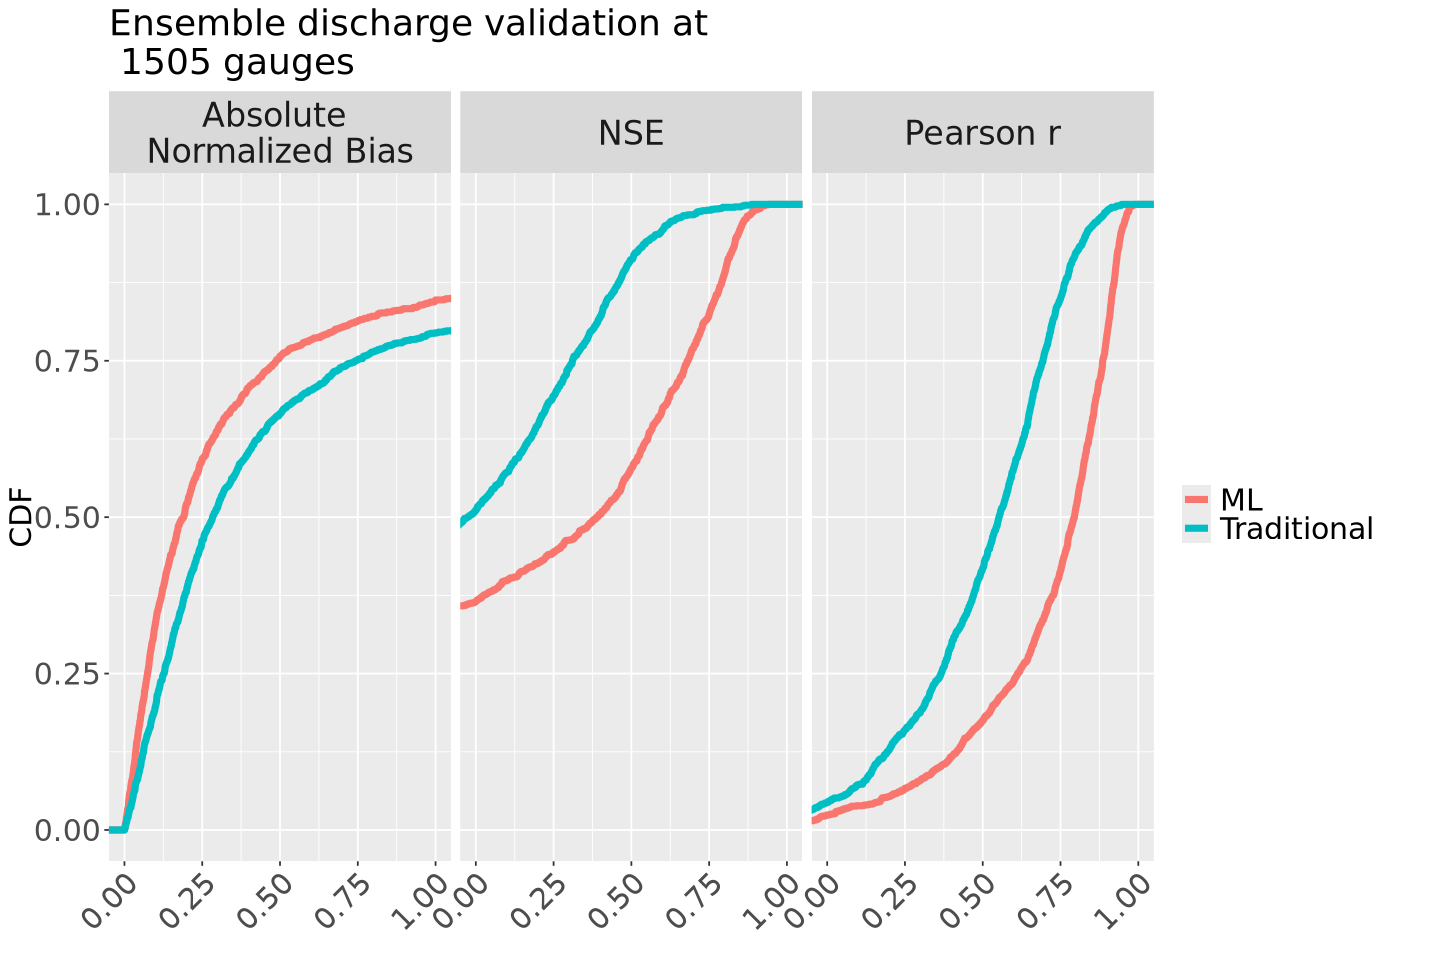

In [7]:
library(dplyr)
library(tidyr)
library(ggplot2)

validated_models_SO=readRDS('/nas/cee-water/cjgleason/colin/SWOT_global_Q_paper/devset_val_SO_noswot.rds')%>%
    left_join(bad_gauges,by='reach_id')%>%
    filter(is.na(bad))%>%
    select(-bad,-nbias)

validated_models_SO$model[validated_models_SO$model=='ensemble_Q'] ='All'
validated_models_SO$model[validated_models_SO$model=='trad_ensemble'] ='Traditional'
validated_models_SO$model[validated_models_SO$model=='ML_ensemble'] ='ML'

validated_models_SO=validated_models_SO%>%
    filter(model == 'Traditional' |model == 'ML' )

plotter=gather(validated_models_SO,stat,value,-model,-reach_id)%>%
    filter(stat!='sigE')

plotter$stat[plotter$stat=='abs_bias']='Absolute \nNormalized Bias'
plotter$stat[plotter$stat=='pearson']='Pearson r'


num_gauges=length(unique(plotter$reach_id))

p1=ggplot(plotter)+
    stat_ecdf(aes(x=value,col=model),lwd=2)+
    # scale_color_manual(values=colors)+
    # scale_linewidth_manual(values=lwds)+
    coord_cartesian(xlim=c(0,1))+
         theme(legend.text=element_text(size=18))+
         theme(axis.title.y=element_text(size=18))+
         theme(legend.title=element_blank())+
         theme(title=element_text(size=18))+
         theme(axis.text.x=element_text(size=18, angle=45,hjust=1))+
         theme(axis.text.y=element_text(size=18))+
         theme(axis.title=element_text(size=14, angle=45))+
         theme(legend.margin=margin(c(1,5,5,5)))+
         theme(legend.box.margin = margin(1, 40, 1, 1))+
         theme(strip.text = element_text(size = 20))+
    xlab('')+
    ylab('CDF')+
    ggtitle(paste('Ensemble discharge validation at\n', num_gauges, 'gauges'))
    
options(repr.plot.width=12, repr.plot.height=8)
 p1  + facet_wrap(vars(stat))



In [1]:
#read in SDI_small
#read the giant dataframe----------
SES_df=readRDS('/nas/cee-water/cjgleason/colin/SWOT_global_Q_paper/SES_dataframe.rds')

SES_df$model[SES_df$model=='ML_ensemble']='ML'
SES_df$model[SES_df$model=='Traditional_ensemble']='Traditional'
# #remove any no data entries-----------
# filter(!is.na(model))%>%
# filter(model=='ensemble_Q')%>%
# filter(!is.na(spearman))%>%
# #rename to join
# mutate(model ='Ensemble')


In [9]:
explore_errors=SES_df%>%
    left_join(validated_models_SO,by=c('model','reach_id'))%>%
    filter(!is.na(NSE))%>%
    filter(model == 'ML')%>%
#remove bad reaches
left_join(bad_gauges,by='reach_id')%>%
    filter(is.na(bad))%>%
    select(-bad)
head(explore_errors)

model,reach_id,SES,geometry,sigE,NSE,pearson,abs_bias
<chr>,<dbl>,<dbl>,<LINESTRING>,<dbl>,<dbl>,<dbl>,<dbl>
ML,21601000091,0.8021585,LINESTRING (7.090623 43.930...,0.60680724,0.2805770,0.77955245,0.24133727
ML,21602300221,0.4597701,LINESTRING (4.648424 44.263...,0.06650968,-0.4692876,0.38995968,0.92552274
ML,21602300241,0.2231453,LINESTRING (4.679711 44.438...,0.00210960,-0.4051775,0.07634784,0.99894182
ML,21602300351,-0.5684211,LINESTRING (4.721499 44.093...,0.13943393,0.6269785,0.90589099,0.23061700
ML,21602300471,-0.3368768,LINESTRING (4.873617 44.959...,0.15775128,0.6559730,0.90294380,0.21098976
ML,21602400121,0.6334215,LINESTRING (5.511695 45.255...,0.13087570,0.7640012,0.89810128,0.02913157


Adding missing grouping variables: `model`


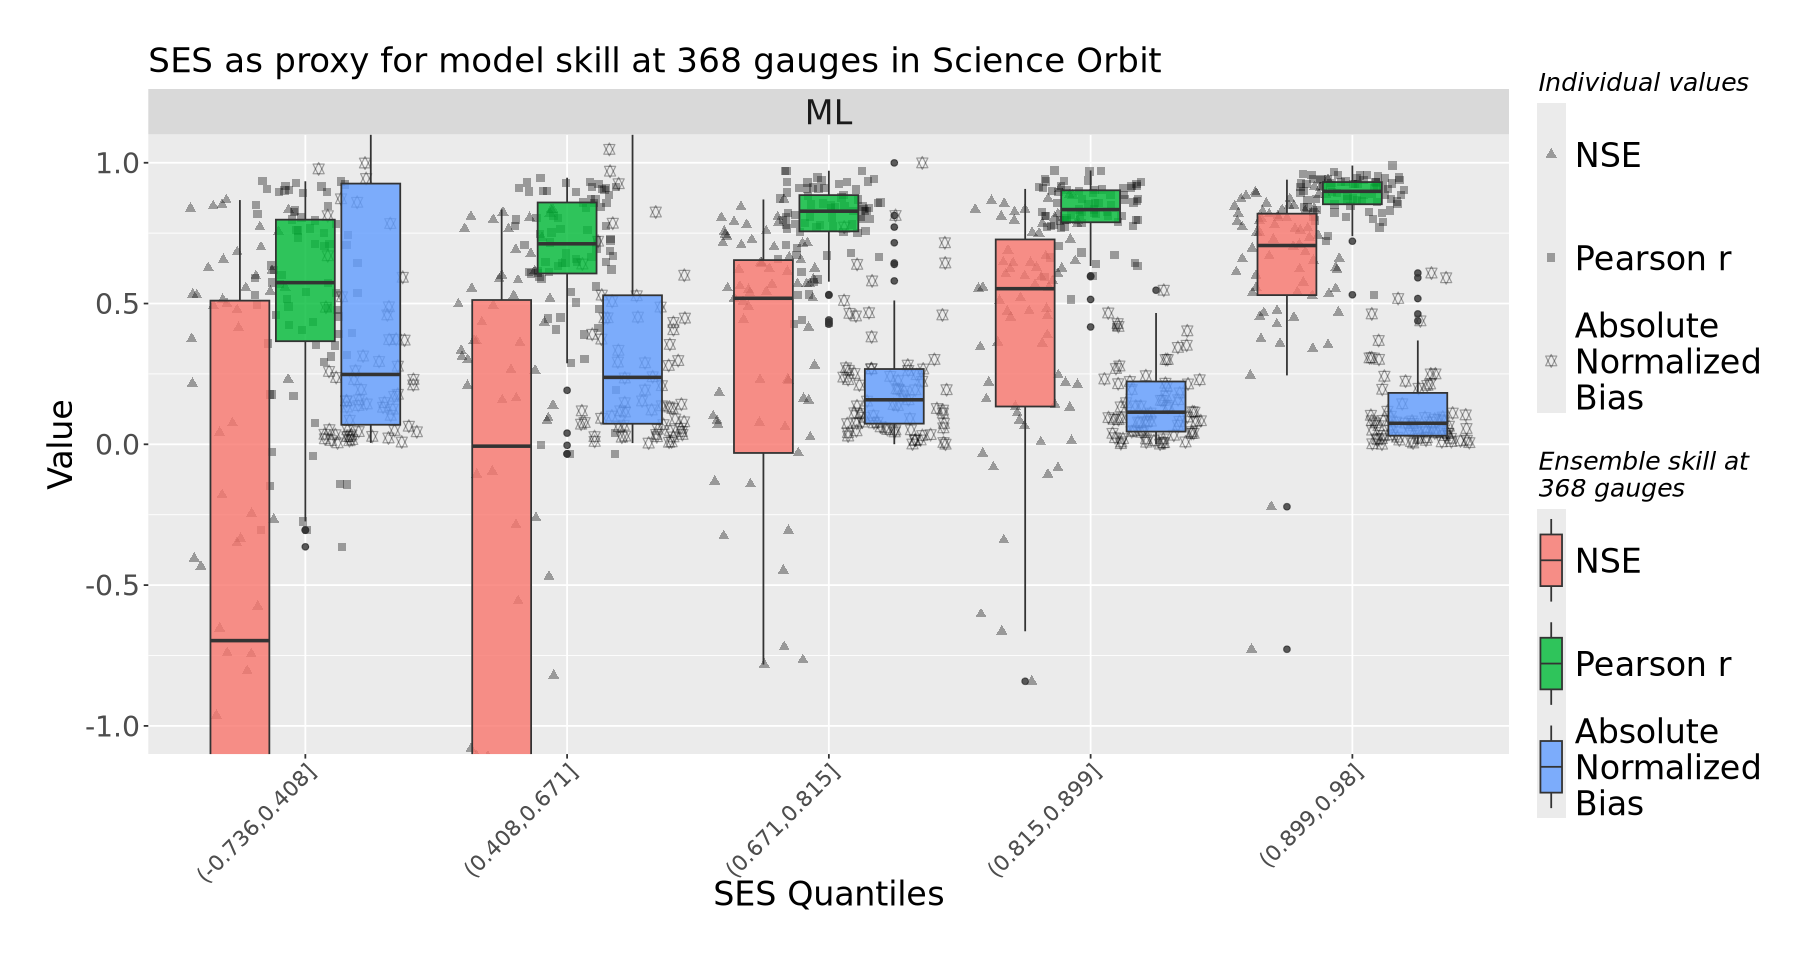

In [10]:
plotter1=select(explore_errors,SES,abs_bias,NSE,pearson)

plotter2=plotter1%>%
    mutate(binned_lat=cut(SES,breaks=round(quantile(plotter1$SES,probs=seq(0,1,by=0.20)),digits=3),na.rm=TRUE))%>%
    group_by(binned_lat)%>%
    mutate(nreaches=n())%>%
    select(-SES)%>%
    filter(!is.na(binned_lat))%>%
     gather(stat,value,-binned_lat,-nreaches,-model)


plotter2$stat[plotter2$stat=='abs_bias']="Absolute\nNormalized\nBias"
plotter2$stat[plotter2$stat=='pearson']="\nPearson r\n"
plotter2$stat[plotter2$stat=='NSE']="\nNSE\n"

# # plotter2=filter(plotter2,stat!="\nNSE\n")

num_gauges=length(unique(explore_errors$reach_id))
shapes=c('triangle','square','star')


p1=ggplot(plotter2)+

    geom_point(aes(x=binned_lat,y=value,shape=stat),size=2,position=position_jitterdodge(),alpha=0.35)+
    geom_boxplot(aes(x=binned_lat,y=value,fill=stat),alpha=0.8)+


scale_shape_manual(values=shapes)+
    # theme(axis.text.x = element_text(angle = 0, hjust = 1))+
    # annotate('text',x=plotter2$binned_lat,y=1.8,label=paste(plotter2$nreaches,'gauges'),angle=0,size=5)+
    # guides(shape='none')+
    ylab('Value')+
    xlab('SES Quantiles')+
theme(plot.margin = unit(c(1,1,1,1), "cm"))+
         theme(legend.text=element_text(size=20))+
         theme(axis.title.y=element_text(size=20))+
         theme(axis.title.x=element_text(size=20))+
         # theme(legend.title=element_text)+
     theme(axis.text.x=element_text(size=13, angle=45,hjust=1))+
         theme(axis.text.y=element_text(size=17))+
    coord_cartesian(ylim=c(-1,1))+
    theme(title=element_text(size=17))+
    labs(fill=paste0("Ensemble skill at\n",num_gauges, " gauges"),
         shape='Individual values')+
  theme(legend.title=element_text(size = 15, face = "italic"))+
     ggtitle(paste('SES as proxy for model skill at', num_gauges ,'gauges in Science Orbit'))
     # scale_fill_fermenter(palette="Spectral")

options(repr.plot.width=15, repr.plot.height=8)

 p1 +facet_wrap(vars(model))+
theme(strip.text = element_text(size = 20))

ggsave(plot=p1,'/nas/cee-water/cjgleason/colin/SWOT_global_Q_paper/Figures/SES figure.png',width=15,height=8)